# Tybalt latent space arithmetic with high grade serous ovarian cancer subtypes

Recent applications of generative models (GANs and VAEs) in image processing has demonstrated the remarkable ability of the latent dimensions to capture a meaningful manifold representation of the input space. Here, we assess if the VAE learns a latent space that can be mathematically manipulated to reveal insight into the gene expression activation patterns of high grade serous ovarian cancer (HGSC) subtypes.

Several previous studies have reported the presence of four gene expression based HGSC subtypes. However, we recently [published a paper](https://doi.org/10.1534/g3.116.033514) that revealed the inconsistency of subtype assignments across populations. We observed repeatable structure in the data transitioning between setting clustering algorithms to find different solutions. For instance, when setting algorithms to find 2 subtypes, the mesenchymal and immunoreactive and the proliferative and differentiated subtype consistently collapsed together. These observations may suggest that the subtypes exist on a gene expression continuum of differential activation patterns, and may only be artificially associated with "subtypes". Here, we test if the VAE can help to identify some differential patterns of expression.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
sns.set(style='white', color_codes=True)
sns.set_context('paper', rc={'font.size':12, 'axes.titlesize':15, 'axes.labelsize':20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})   

In [4]:
# Set seed for plotting
np.random.seed(123)

In [5]:
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
rnaseq_df.shape

(10459, 5000)

In [6]:
ov_file = os.path.join('data', 'ov_subtype_info.tsv')
ov_df = pd.read_table(ov_file, index_col=0)
ov_df.head(2)

,DATASET,SUBTYPE,AGE,PLATINUM-STATUS,STAGE,GRADE,TUMORRESIDUALDISEASE,SURVIVALSTATUS,SURVIVALMONTHS,RECURRENCE-STATUS,...,Proliferative ssGSEA raw score,Differentiated ssGSEA normalized score,Immunoreactive ssGSEA normalized score,Mesenchymal ssGSEA normalized score,Proliferative ssGSEA normalized score,Differentiated-binary,Immunoreactive-binary,Mesenchymal-binary,Proliferative-binary,SILHOUETTE WIDTH
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1357-01,TCGA-discovery,Immunoreactive,52.0,unknown,IIIB,G3,unknown,LIVING,unknown,unknown,...,127.0,0.765,0.948,0.406,0.169,1,1,0,0,0.184202
TCGA-04-1519-01,TCGA-discovery,Proliferative,48.0,unknown,IIIC,G3,unknown,unknown,unknown,unknown,...,"2,578.4",0.555,0.128,0.331,0.750,1,0,0,1,0.088401


In [7]:
encoded_file = os.path.join('data', "encoded_rnaseq_onehidden_warmup_batchnorm.tsv")
encoded_df = pd.read_table(encoded_file, index_col=0)
print(encoded_df.shape)
encoded_df.head(2)

(10459, 100)


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
TCGA-02-0047-01,0.000000,7.870012,0.0,0.0,0.071894,1.981403,2.580404,4.991513,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.731716,0.0,0.0,0.0,0.000000
TCGA-02-0055-01,0.397321,4.752499,0.0,0.0,0.000000,0.000000,3.468984,0.235408,1.999857,0.172326,...,0.0,1.645057,0.289536,0.427183,0.0,3.674683,0.0,0.0,0.0,1.433402


In [8]:
# Subset and merge the HGSC subtype info with the latent space feature activations
ov_samples = list(set(encoded_df.index) & (set(ov_df.index)))

ov_encoded = encoded_df.loc[ov_samples, ]
ov_encoded_subtype = pd.merge(ov_df.loc[:, ['SUBTYPE', 'SILHOUETTE WIDTH']], ov_encoded,
                              how='right', left_index=True, right_index=True)
ov_encoded_subtype = ov_encoded_subtype.assign(subtype_color = ov_encoded_subtype['SUBTYPE'])

ov_subtype_color_dict = {'Differentiated': 'purple',
                         'Immunoreactive': 'green',
                         'Mesenchymal': 'blue',
                         'Proliferative': 'red'}
ov_encoded_subtype = ov_encoded_subtype.replace({'subtype_color': ov_subtype_color_dict})

print(ov_encoded_subtype.shape)
ov_encoded_subtype.head(2)

(295, 103)


,SUBTYPE,SILHOUETTE WIDTH,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,100,subtype_color
TCGA-04-1364-01,Proliferative,0.259937,0.000000,0.0,0.0,1.476984,0.075770,8.324831,0.0,3.793178,...,0.00000,0.0,0.000000,4.903029,1.836334,0.0,0.972002,7.799475,0.000000,red
TCGA-25-1626-01,Mesenchymal,0.370017,1.119394,0.0,0.0,0.000000,5.980619,0.427655,0.0,3.140723,...,2.11542,0.0,0.903048,0.000000,6.953216,0.0,0.000000,0.000000,3.680222,blue


In [9]:
# Get the HGSC mean feature activation
ov_mean_subtypes = ov_encoded_subtype.groupby('SUBTYPE').mean()
ov_mean_subtypes

,SILHOUETTE WIDTH,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
SUBTYPE,,,,,,,,,,,,,,,,,,,,,
Differentiated,0.009807,1.136645,0.063230,1.084596,0.030669,4.319315,2.162740,0.117676,1.828255,0.147573,...,0.029515,0.870131,0.231958,0.539399,0.306902,1.152863,0.068156,0.134011,2.068712,0.551172
Immunoreactive,0.101423,0.540490,0.098282,1.239212,0.055656,4.013140,0.576003,0.228713,1.508975,0.403625,...,0.102097,0.425375,1.075524,0.976115,1.152676,1.725361,0.015276,0.296640,0.524122,0.868875
Mesenchymal,0.184519,1.141423,0.073041,0.506510,0.063834,3.769120,0.796414,0.089175,2.941976,0.322914,...,0.201935,2.217084,0.235209,0.881876,0.599195,3.461850,0.000000,0.107133,0.603792,1.895198
Proliferative,0.129997,1.384532,0.092532,1.010996,0.332801,3.214791,3.225281,0.033968,4.260623,0.501052,...,0.127314,0.398148,0.247336,0.757045,0.902759,1.298532,0.036185,0.165628,2.275845,0.280951


## HGSC Subtype Arithmetic

Because of the relationship observed in the consistent clustering solutions, perform the following subtractions

1. Immunoreactive - Mesenchymal
2. Differentiated - Proliferative

The goal is to observe the features with the largest difference between the aformentioned comparisons. The differences should be in absolute directions

### 1) Immunoreactive - Mesenchmymal

In [10]:
mes_mean_vector = ov_mean_subtypes.loc['Mesenchymal', [str(x) for x in range(1, 101)]]
imm_mean_vector = ov_mean_subtypes.loc['Immunoreactive', [str(x) for x in range(1, 101)]]

In [11]:
high_immuno = (imm_mean_vector - mes_mean_vector).sort_values(ascending=False).head(2)
high_mesenc = (imm_mean_vector - mes_mean_vector).sort_values(ascending=False).tail(2)

print("Features with large differences: Immuno high, Mesenchymal low")
print(high_immuno)
print("Features with large differences: Mesenchymal high, Immuno low")
print(high_mesenc)

Features with large differences: Immuno high, Mesenchymal low
77    3.147650
56    2.911636
dtype: float64
Features with large differences: Mesenchymal high, Immuno low
92   -1.791708
87   -3.247565
dtype: float64


In [12]:
# Select to visualize encoding 56 because it has high immuno and low everything else
ov_mean_subtypes.loc[:, ['87', '77', '56']]

,87,77,56
SUBTYPE,,,
Differentiated,2.290071,2.962777,0.882760
Immunoreactive,3.508898,4.956166,3.446800
Mesenchymal,6.756463,1.808515,0.535164
Proliferative,1.197723,4.757647,0.614116


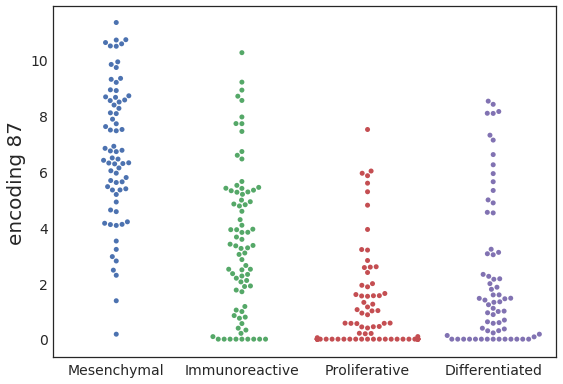

In [13]:
# Node 87 has high mesenchymal, low immunoreactive
node87_file = os.path.join('figures', 'node87_distribution_ovsubtype.pdf')
g = sns.swarmplot(y = '87', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 87')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(node87_file)

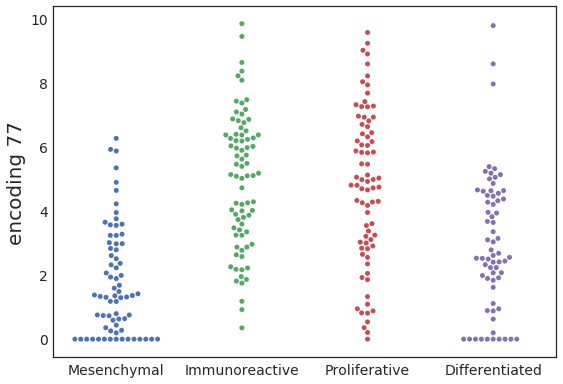

In [14]:
# Node 77 has high immunoreactive, low mesenchymal
node77_file = os.path.join('figures', 'node77_distribution_ovsubtype.pdf')
g = sns.swarmplot(y = '77', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 77')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(node77_file)

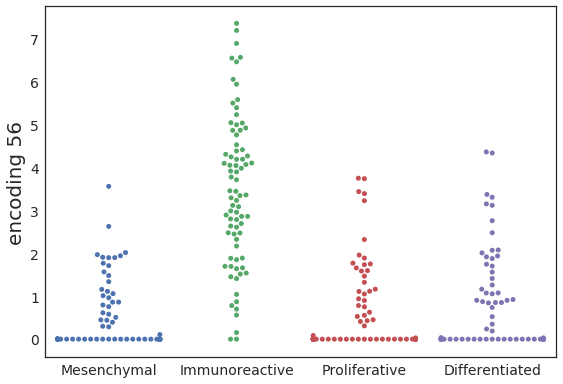

In [15]:
# Node 56 has high immunoreactive, low mesenchymal (and prolif/diff)
node56_file = os.path.join('figures', 'node56_distribution_ovsubtype.pdf')
g = sns.swarmplot(y = '56', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 56')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(node56_file)

### 2) Differentiated - Proliferative

In [16]:
pro_mean_vector = ov_mean_subtypes.loc['Proliferative', [str(x) for x in range(1, 101)]]
dif_mean_vector = ov_mean_subtypes.loc['Differentiated', [str(x) for x in range(1, 101)]]

In [17]:
high_differ = (dif_mean_vector - pro_mean_vector).sort_values(ascending=False).head(2)
high_prolif = (dif_mean_vector - pro_mean_vector).sort_values(ascending=False).tail(2)

print("Features with large differences: Differentiated high, Proliferative low")
print(high_differ)
print("Features with large differences: Proliferative high, Differentiated low")
print(high_prolif)

Features with large differences: Differentiated high, Proliferative low
38    3.921864
63    3.438013
dtype: float64
Features with large differences: Proliferative high, Differentiated low
8    -2.432367
79   -3.946322
dtype: float64


In [18]:
# Select to visualize encoding 56 because it has high immuno and low everything else
ov_mean_subtypes.loc[:, ['38', '79']]

,38,79
SUBTYPE,,
Differentiated,7.491237,1.592094
Immunoreactive,7.556837,0.847682
Mesenchymal,6.159492,2.255257
Proliferative,3.569372,5.538416


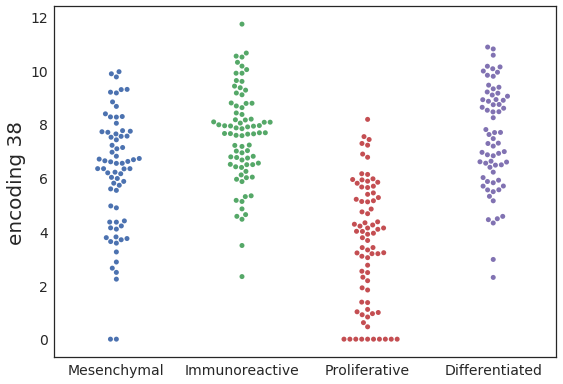

In [19]:
# Node 38 has high differentiated, low proliferative
node38_file = os.path.join('figures', 'node38_distribution_ovsubtype.pdf')
g = sns.swarmplot(y = '38', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 38')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(node38_file)

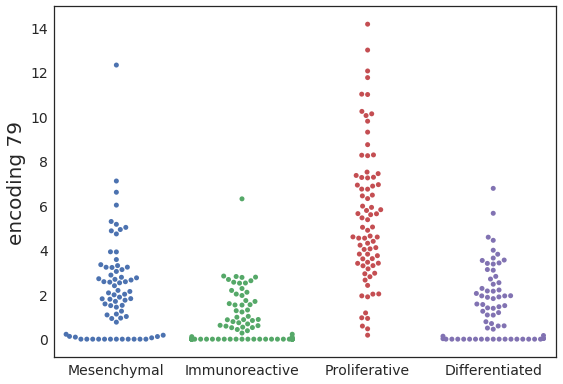

In [20]:
# Node 79 has high proliferative, low differentiated
node79_file = os.path.join('figures', 'node79_distribution_ovsubtype.pdf')
g = sns.swarmplot(y = '79', x = 'SUBTYPE', data=ov_encoded_subtype,
                  order=['Mesenchymal', 'Immunoreactive', 'Proliferative', 'Differentiated']);
g.set(xlabel='', ylabel='encoding 79')
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig(node79_file)

### Explore weights that explain the nodes

In [21]:
def get_high_weight(weight_matrix, node, high_std=2.5, direction='positive'):
    """
    Determine high weight genes given a gene weight matrix and feature
    Output tab separated file
    """
    genes = weight_matrix.loc[node, :].sort_values(ascending=False)
    if direction == 'positive':
        node_df = (genes[genes > genes.std() * high_std])
        abbrev = 'pos'
    elif direction == 'negative':
        node_df = (genes[genes < -1 * (genes.std() * high_std)])
        abbrev = 'neg'

    node_df = pd.DataFrame(node_df).reset_index()
    node_df.columns = ['genes', 'weight']
    
    node_base_file = 'hgsc_node{}genes_{}.tsv'.format(node, abbrev)
    node_file = os.path.join('results', node_base_file)
    node_df.to_csv(node_file, index=False, sep='\t')
    
    return node_df

In [22]:
# Obtain the decoder weights
weight_file = os.path.join('results', 'tybalt_gene_weights.tsv')

weight_df = pd.read_table(weight_file, index_col=0)
weight_df.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
encodings,,,,,,,,,,,,,,,,,,,,,
1,-0.038720,0.016661,0.029607,0.039584,-0.001849,0.012594,0.016473,0.012619,-0.041976,-0.035155,...,0.015413,-0.021422,-0.009609,-0.016911,0.001458,-0.014941,-0.008457,-0.028340,-0.004947,0.014693
2,-0.038551,0.025872,0.026606,0.014903,0.011040,-0.018997,0.002153,-0.003017,-0.042659,-0.044308,...,-0.007668,0.000821,0.020055,0.012365,0.010221,0.010597,-0.018201,0.031298,-0.014771,-0.012871


In [23]:
# Output high weight genes for nodes representing mesenchymal vs immunoreactive
node87pos_df = get_high_weight(weight_df, node=87)
node87neg_df = get_high_weight(weight_df, node=87, direction='negative')

node77pos_df = get_high_weight(weight_df, node=77)
node77neg_df = get_high_weight(weight_df, node=77, direction='negative')

node56pos_df = get_high_weight(weight_df, node=56)
node56neg_df = get_high_weight(weight_df, node=56, direction='negative')

In [24]:
# Output high weight genes for nodes representing proliferative vs differentiated
node79pos_df = get_high_weight(weight_df, node=79)
node79neg_df = get_high_weight(weight_df, node=79, direction='negative')

node38pos_df = get_high_weight(weight_df, node=38)
node38neg_df = get_high_weight(weight_df, node=38, direction='negative')